## Thực nghiệm thuật toán xác định trọng số cho mạng Nơ ron tế bào bậc hai (SOCeNNs) bằng giải thuật di truyền (GA)

### Thuật toán GASOCeNNs

##### Khai báo các thư viện

In [5]:
import numpy as np # thư viện chuyên làm việc với các mảng và ma trận
from numba import jit # tăng tốc độ biên dịch ma Python
from scipy.signal import convolve2d # tính tích chập
from scipy.integrate import ode # giải phương trình vi phân
from PIL import Image as img # hỡ trợ đọc, xuất, hiển thị file ảnh

##### Xây dựng class GASOCeNNs, khai báo các biến và các hàm cần thiết

In [6]:
# hàm trạng thái - phương trình vi phân
# x là hàm số có dạng x(t)
# uB1 là kết quả tích chập giữa u và B1
# uB2 là kết quả tích chập bậc hai giữa u và B2
def hamTrangThai(t, x, uB1, uB2, A1, A2, I, n, m):
    x = x.reshape(n, m)
    dx = -x + uB1 + convolve2d(hamDauRa(x),A1,'same') + uB2 + tichChapBacHai(hamDauRa(x),A2) + I
    return dx.flatten()

# hàm đầu ra - hàm bão hòa
def hamDauRa(x):
    return 0.5 * (abs(x + 1) - abs(x - 1))

# Hàm tính sai số (theo phần trăm) - tính độ chênh lệch giữa kết quả đầu ra tìm được và đầu ra mong muốn của một mẫu
def saiSo(d,y):
    m, n = y.shape
    return np.round(np.sum(0.5*(d-y)**2)/2./m/n, 3)

# Hàm lai hai số (-3.22 và 6.45 tạo thành 3.|45)
def lai(a,b):
    if(a>0):
        return np.round(a//1+np.abs(b)-np.abs(b)//1,2)
    else:
        return np.round(a//1-np.abs(b)+np.abs(b)//1,2)
    
# hàm đột biến
def dotBien(a):
    a_ = list(str(a) if a<0 else "+"+str(a))
    k = np.random.randint(len(a_))
    if(a_[k] == '+'):
        a_[k] = '-'
    elif(a_[k] == '-'):
        a_.remove('-')
    elif(a_[k] != '.'):
        a_[k] = str(np.random.randint(10))
    if(a_[0] == '+'):
        a_.remove('+')
    return float(''.join(a_))

# hàm tính tích chập bậc hai giữa bộ ma trận phản hồi bậc hai A21.. A29 với ma trận đầu ra y (hoặc bộ ma trận điều khiển B21 - B29 với ma trận đầu vào u) (xem lại công thức mạng Nơ-ron tế bào bậc hai)
@jit()#tăng tốc độ tính toán
def tichChapBacHai(y, A):#y là ma trận đầu ra y (hoặc ma trận đầu vào u), A là bộ ma trận phản hồi bậc hai A21.. A29 (hoặc bộ ma trận điều khiên bậc hai B21.. B29)
    # A là một mảng có 9 phần tử vỗi mỗi một phần tử là một ma trận 3x3
    m, n = y.shape
    ketQua = np.zeros(y.shape) # tạo ma trận chứa toàn số 0 có kích thước bằng ma trận y để lưu kết quả
    for i in range(m):
        for j in range(n):
            # xét từng điểm trên ma trận y kích thước m, n
            for k in range(3):#0.. 2
                for l in range(3):#0.. 2
                    # xét từng ma trận trong bộ A21 đến A29 (trong code là A[0] đến A[8])
                    x = k*3+l # ma trận A[x] đang được xét
                    for r in range(-1,2):#-1.. 1
                        for s in range(-1,2):#-1.. 1
                            # nhân từng số của ma trận láng giềng y(i,j;r,s) với ma trận A[x]
                            if(0<=i+r<m and 0<=j+s<n and 0<=i+1-k<m and 0<=j+1-l<n):#kiểm tra biên
                                ketQua[i][j]+=A[x][r][s]*y[i+1-k][j+1-l]*y[i+r][j+s]
    return ketQua

# Tạo ma trận 3x3 đối xứng tâm từ mảng gồm 5 phần tử
def taoMaTranDoiXung(arr1):#giả sử cho mảng [1,2,3,4,5]
    arr2 = arr1[-2::-1].copy()#tạo mảng phụ [4,3,2,1]
    return np.append(arr1,arr2).reshape(3,3)#kết hợp hai mảng rồi chuyển về dạng ma trận 3x3
    # 1,2,3
    # 4,5,4
    # 3,2,1

# Hàm tạo số ngẫu nhiên từ -9.99 đến 9.99
def ngauNhien():
    return np.random.randint(-999,1000)/100.

# load file ảnh và chuẩn hóa về dạng ảnh hai màu đen trắng, trả về ma trận ảnh (-1: đen, 1: trắng)
def loadImg(path):
    return np.round(np.array(img.open(path).convert('RGB'), dtype=float)[:,:,0]/255.*2.-1., 3)

# lưu lại bộ trọng số
def saveTrongSo(boTrongSo):
    np.savetxt('TrongSoBac2/boTrongSo.txt', boTrongSo)

# hiển thị bộ ma trận trọng số (không phải là bộ trọng số)
def printMaTranTrongSo(boTrongSo):
    A1 = taoMaTranDoiXung(boTrongSo[:5])
    A2 = np.array([taoMaTranDoiXung(boTrongSo[5*i+5:5*i+10]) for i in range(9)])
    B1 = taoMaTranDoiXung(boTrongSo[50:55])
    B2 = np.array([taoMaTranDoiXung(boTrongSo[5*i+55:5*i+60]) for i in range(9)])
    I = boTrongSo[100] 
    print('A1 = \n', A1)
    for i in range(9):
        print(f'A2{i+1} = \n', A2[i])    
    print('B1 = \n', B1)
    for i in range(9):
        print(f'B2{i+1} = \n', B2[i])
    print('I =', I)

class GASOCeNNs:
    def __init__(self, boTrongSo, E0, soLanLai, tiLeDotBien, soLanChay = 10000):
        # load các mẫu dữ liệu
        self.samples = [
            # mỗi mẫu dữ liệu huấn luyện bao gồm hai ảnh (ảnh đầu vào u và ảnh đầu ra mong muốn d là kết quả lọc biên của ảnh u)
            [loadImg(f'images/u{i}.png'), loadImg(f'images/d{i}.png')] for i in [1,2,7,8]
        ]

        # số lượng trọng số trong quần thể trọng số (gồm 20 ma trận mỗi ma trận 5 trọng số và mức ngưỡng I)
        self.slTrongSo = 101

        # số lượng mẫu
        self.slMau = len(self.samples)

        # bộ trọng số ban đầu
        # self.boTrongSo = np.array([ngauNhien() for i in range(self.slTrongSo)])
        # self.boTrongSo = np.array([0.]*75+[ngauNhien()]*26)
        # self.boTrongSo = np.array([0.]*self.slTrongSo)
        # self.boTrongSo = np.array([-1.23,4.56,-7.89,0.,0.]*20+[1.])
        self.boTrongSo = boTrongSo

        # mảng lưu lại giá trị sai số của từng mẫu
        self.E = [10000.]*len(self.samples)

        # sai số trung bình cho phép
        # self.E0 = 0.05
        self.E0 = E0

        # Số lần lai khi xét một trọng số trong vòng lặp nhỏ
        self.soLanLai = soLanLai

        # Tỉ lệ đột biến
        self.tiLeDotBien = tiLeDotBien

        # số lần chạy vòng lặp lớn (mỗi vòng lặp lớn sẽ duyệt toàn bộ bộ trọng số)
        self.soLanChay = soLanChay

    # chạy mạng SOCeNNs cho một mẫu để tính toán đầu ra với các tham số gồm ma trận đầu vào u, bộ trọng số, giá trị ban đầu (x0, t0), bước nhảy dt
    def runSOCeNNs(self, u, boTrongSo, dt = 0.02, x0 = 0):
        # tạo các ma trận A1, A21 - A29, B1, B21 - B29 và mức ngưỡng I từ bộ trọng số
        A1 = taoMaTranDoiXung(boTrongSo[:5])
        A2 = np.array([taoMaTranDoiXung(boTrongSo[5*i+5:5*i+10]) for i in range(9)])
        B1 = taoMaTranDoiXung(boTrongSo[50:55])
        B2 = np.array([taoMaTranDoiXung(boTrongSo[5*i+55:5*i+60]) for i in range(9)])
        I = boTrongSo[100]

        # xác định kích thước của ma trận đầu vào
        n, m = u.shape

        # xác định giá trị ban đầu (x0, t0)
        x0 = u.copy()
        t0 = 0.

        # khởi tạo biến giải phương trình vi phân từ class ODE của thư viên Scipy
        ptvp = ode(hamTrangThai).set_integrator('vode', method='adams')

        # khai báo giá trị ban đầu của phương trình vi phân
        ptvp.set_initial_value(x0.flatten(), t0) # lệnh flatten dùng để biến đổi ma trận về dạng mảng (đầu vào và đầu ra của ode phải là một số hoặc mảng)

        # khai báo các tham số của phương trình vi phân
        ptvp.set_f_params(convolve2d(u,B1,'same'), tichChapBacHai(u,B2), A1, A2, I, n, m)

        # giải phương trình vi phân
        x = ptvp.integrate(dt).reshape(n, m)

        # tính toán đầu ra
        y = hamDauRa(x)

        # trả về đầu ra đã được chuẩn hóa về -1; 1
        return np.sign(y)
    
    # chạy mạng SOCeNNs cho tất cả các mẫu
    def runAllSample(self, boTrongSo):
        yCon = []
        ECon = []
        for sample in self.samples: # chạy mạng nơ ron cho từng mẫu để tính toán đầu ra
            y = self.runSOCeNNs(sample[0], boTrongSo)
            yCon.append(y)
            ECon.append(saiSo(y, sample[1]))
        return yCon, ECon
    
    # vòng lặp nhỏ - tối ưu trọng số thử k trong bộ trọng số
    def toiUuTrongSo(self, k):# E là tập sai số ứng với bộ trọng số hiện tại
        boTrongSoCon = self.boTrongSo.copy()
        for i in range(self.soLanLai):
            cha, me = self.boTrongSo[np.random.randint(self.slTrongSo)], self.boTrongSo[np.random.randint(self.slTrongSo)]
            con = lai(cha, me)
            if(np.random.random() < self.tiLeDotBien):
                con = dotBien(con)
            # con = ngauNhien()
            boTrongSoCon[k] = con # thay trọng số mới (con) vào vị trí k của bộ trọng số
            yCon, ECon = self.runAllSample(boTrongSoCon)
            if(np.average(ECon) <= np.average(self.E)):
                self.E = ECon.copy()
                self.y = yCon.copy()
                self.boTrongSo = boTrongSoCon.copy()

    # giải thuật di truyền GA để xác định trọng số cho mạng nơ ron tế bào bậc hai SOCeNNs
    def runGASOCeNNs(self):
        for i in range(self.soLanChay):
            for j in range(self.slTrongSo):
                self.toiUuTrongSo(j)
                print(f'Chạy lần thứ {i+1}, xét trọng số thứ {j+1} (trọng số thứ {j%5+1} của ma trận {"A" if j<50 else "B"}{1 if j%50<5 else 2}{"" if j%50//5==0 else j%50//5}), sai số trung bình: {np.round(np.average(self.E), 3)}')
            # print(f'Bộ trọng số: {self.boTrongSo}')
            if(np.average(self.E) <= self.E0):
                print('Đạt tới sai số cho phép')
                break
        print('Kết thúc')
        # printMaTranTrongSo(self.boTrongSo)

In [7]:
# Khởi tạo GASOCeNNs
ga = GASOCeNNs(
    boTrongSo = [-1.23, 4.56, -7.89, 0., 0.]*20+[-1],
    E0 = 0.05,
    soLanLai = 3,
    tiLeDotBien = 0.05,
)

#### Thực nghiệm

##### Thực nghiệm chạy GASOCeNNs

In [8]:
ga.runGASOCeNNs()

Chạy lần thứ 1, xét trọng số thứ 1 (trọng số thứ 1 của ma trận A1), sai số trung bình: 0.55
Chạy lần thứ 1, xét trọng số thứ 2 (trọng số thứ 2 của ma trận A1), sai số trung bình: 0.55
Chạy lần thứ 1, xét trọng số thứ 3 (trọng số thứ 3 của ma trận A1), sai số trung bình: 0.535
Chạy lần thứ 1, xét trọng số thứ 4 (trọng số thứ 4 của ma trận A1), sai số trung bình: 0.535
Chạy lần thứ 1, xét trọng số thứ 5 (trọng số thứ 5 của ma trận A1), sai số trung bình: 0.535
Chạy lần thứ 1, xét trọng số thứ 6 (trọng số thứ 1 của ma trận A21), sai số trung bình: 0.534
Chạy lần thứ 1, xét trọng số thứ 7 (trọng số thứ 2 của ma trận A21), sai số trung bình: 0.534
Chạy lần thứ 1, xét trọng số thứ 8 (trọng số thứ 3 của ma trận A21), sai số trung bình: 0.511
Chạy lần thứ 1, xét trọng số thứ 9 (trọng số thứ 4 của ma trận A21), sai số trung bình: 0.511
Chạy lần thứ 1, xét trọng số thứ 10 (trọng số thứ 5 của ma trận A21), sai số trung bình: 0.495
Chạy lần thứ 1, xét trọng số thứ 11 (trọng số thứ 1 của ma trận A2

KeyboardInterrupt: 

##### Đánh giá với bộ dữ liệu đánh giá

In [9]:
sample_test = [[loadImg(f'images/u{i}.png'), loadImg(f'images/d{i}.png')] for i in [3,4,5,6]]
E_test = []
for sample in sample_test:
    # print('Đầu vào: \n', sample[0])
    # print('Đầu ra mong muốn: \n', sample[1])
    print('Chạy mạng nơ ron')
    y = ga.runSOCeNNs(sample[0], ga.boTrongSo)
    # print('Đầu ra sau khi chạy: \n', y)
    e = saiSo(y, sample[1])
    E_test.append(e)
print('Sai số:', np.round(np.average(E_test), 3))

Chạy mạng nơ ron
Chạy mạng nơ ron
Chạy mạng nơ ron
Chạy mạng nơ ron
Sai số: 0.06


##### Đánh giá với ảnh cụ thể (ảnh xám)

In [10]:
list_image = [
    # '1.bmp',
    # '2.gif',
    # '3.png',
    # '4.jpg',
    '5.png',
]
print('Chạy mạng nơ ron:')
for image in list_image:
    print('Chạy với ảnh', image)
    u = loadImg(f'images/input{image}')
    print('Kích thước ảnh:', u.shape)
    # print('Đầu vào: \n', list_test_image[i])
    y = ga.runSOCeNNs(u, ga.boTrongSo)
    y = (y/2.0+0.5)*255
    # print('Đầu ra: \n', y)
    out = img.fromarray(y).convert('RGB')
    out.save(f'images/output{image}')
    print('Hoàn thành')

Chạy mạng nơ ron:
Chạy với ảnh 5.png
Kích thước ảnh: (316, 474)
Hoàn thành


##### Đánh giá với ảnh cụ thể (ảnh màu)

Chạy mạng nơ ron:
Chạy với ảnh 9.jpg
Kích thước ảnh: (355, 474)
Hiển thị ảnh đầu vào


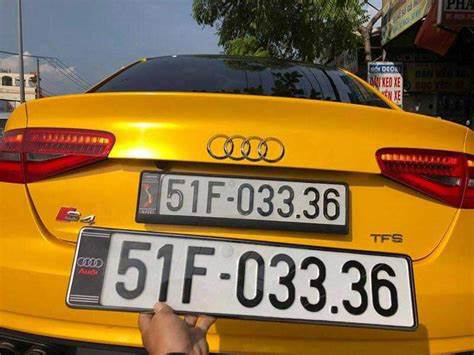

Hiển thị ảnh sau khi xám hóa


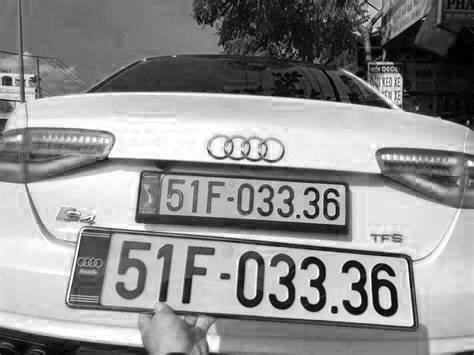

Đang chạy...
Hiển thị ảnh đầu ra


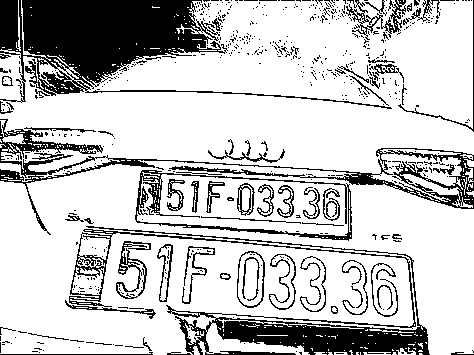

Hoàn thành


In [11]:
list_image = [
    # '7.jpg',
    # '8.jpg',
    '9.jpg',
    # '6.png',
]
print('Chạy mạng nơ ron:')
for image in list_image:
    print('Chạy với ảnh', image)

    # load ảnh
    input = img.open(f'images/input{image}').convert('RGB')
    
    # chuyển về dạng ma trận ảnh
    u = np.array(input)
    u = u[:,:,0]/255.*2.-1.
    
    print('Kích thước ảnh:', u.shape)
    print('Hiển thị ảnh đầu vào')
    display(input)
    print('Hiển thị ảnh sau khi xám hóa')
    display(img.fromarray((u/2.+0.5)*255).convert('RGB'))

    # xử lý ảnh 
    print('Đang chạy...')
    y = ga.runSOCeNNs(u, ga.boTrongSo)

    # chuyển đổi ma trận đầu ra thành ảnh 
    y = (y/2.0+0.5)*255

    # lưu và hiển thị ảnh đầu ra
    out = img.fromarray(y).convert('RGB')
    out.save(f'images/output{image}')
    print('Hiển thị ảnh đầu ra')
    display(out)
    print('Hoàn thành')

In [ ]:
# lưu lại bộ trọng số
saveTrongSo(ga.boTrongSo)